In [29]:
!pip install pandas matplotlib seaborn wordcloud

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

print("Semua pustaka berhasil diimpor.")

Semua pustaka berhasil diimpor.


In [31]:
file_path = 'tokopedia-product-reviews-2019.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat.")
    # Tampilkan 5 baris pertama untuk memastikan data benar
    print("Contoh data:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan Anda sudah mengunggahnya dan namanya benar.")

Dataset berhasil dimuat.
Contoh data:


,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
4,5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40607 entries, 0 to 40606
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    40607 non-null  int64 
 1   text          40607 non-null  object
 2   rating        40607 non-null  int64 
 3   category      40607 non-null  object
 4   product_name  40607 non-null  object
 5   product_id    40607 non-null  int64 
 6   sold          40593 non-null  object
 7   shop_id       40607 non-null  int64 
 8   product_url   40607 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.8+ MB


Jumlah data yang hilang per kolom:
Unnamed: 0       0
text             0
rating           0
category         0
product_name     0
product_id       0
sold            14
shop_id          0
product_url      0
dtype: int64




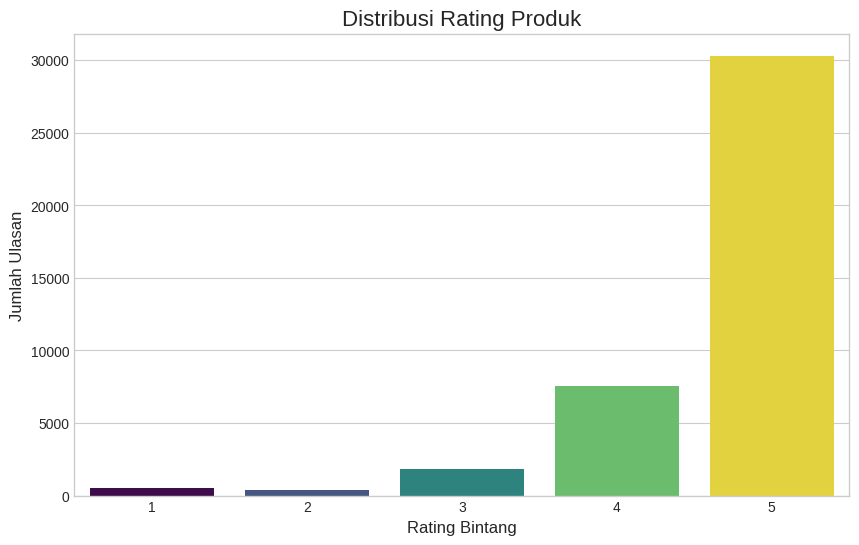

In [32]:
# 1. Informasi dasar dataset
print("Informasi Dataset:")
df.info()

print("\n============================================\n")

# 2. Cek data yang hilang (missing values)
print("Jumlah data yang hilang per kolom:")
print(df.isnull().sum())

print("\n============================================\n")

# 3. Visualisasi distribusi rating
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, palette='viridis', hue='rating', legend=False)
plt.title('Distribusi Rating Produk', fontsize=16)
plt.xlabel('Rating Bintang', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

In [33]:
# 1. Filter ulasan negatif (rating 1 dan 2)
df_negatif = df[df['rating'] <= 2].copy()
print(f"Jumlah ulasan negatif (rating 1 & 2): {len(df_negatif)} ulasan")

# 2. Fungsi untuk membersihkan teks
def bersihkan_teks(teks):
    if not isinstance(teks, str):
        return ""
    teks = teks.lower() # Ubah ke huruf kecil
    teks = re.sub(r'[^a-z\s]', '', teks) # Hapus karakter selain huruf dan spasi
    # Anda bisa menambahkan penghapusan stopwords di sini jika perlu
    return teks

# Terapkan fungsi pembersihan ke kolom ulasan
df_negatif['review_bersih'] = df_negatif['text'].apply(bersihkan_teks)

print("\nContoh ulasan setelah dibersihkan:")
display(df_negatif[['text', 'review_bersih']].head())

Jumlah ulasan negatif (rating 1 & 2): 925 ulasan

Contoh ulasan setelah dibersihkan:


,text,review_bersih
57,Pesanan gx sesuai dgn yg d gambar,pesanan gx sesuai dgn yg d gambar
68,Pengiriman dan respon super cepat. Tpi barang ...,pengiriman dan respon super cepat tpi barang t...
93,barang yg dikirim tidak sesuai pesanan,barang yg dikirim tidak sesuai pesanan
115,"Php, bilang isi ada diseskripsi pas dipesen be...",php bilang isi ada diseskripsi pas dipesen ber...
150,barang jelek copot&#34; terus tmpat taro isinya,barang jelek copot terus tmpat taro isinya


In [34]:
!pip install langchain_community
!pip install replicate

In [35]:
from google.colab import userdata
import os

# ambil token dari colab
api_token = userdata.get('api_token')

# taro token ke env. var.
os.environ['REPLICATE_API_TOKEN'] = api_token

In [36]:
from langchain_community.llms import Replicate

# Ambil granite dari replicate
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct"
)

In [37]:
def klasifikasi_keluhan(ulasan, llm_model):
    """
    Mengklasifikasikan ulasan menggunakan model LLM yang diberikan.
    """
    # Kategori keluhan yang sudah kita tentukan
    kategori = ["Kualitas Produk", "Pengiriman", "Pelayanan Penjual", "Tidak Sesuai Deskripsi", "Lainnya"]

    # Prompt yang jelas untuk mengarahkan model
    prompt = f"""
    Tugas: Analisis ulasan pelanggan berikut dan klasifikasikan ke dalam salah satu dari kategori ini: {', '.join(kategori)}.
    Aturan: Berikan HANYA nama kategori sebagai jawaban. Jangan berikan penjelasan.

    Ulasan: "{ulasan}"

    Kategori:
    """

    try:
        # Panggil model menggunakan metode invoke()
        output = llm_model.invoke(prompt)
        # Bersihkan output dari spasi atau baris baru yang tidak perlu
        hasil_kategori = output.strip()

        # Validasi untuk memastikan output sesuai dengan kategori yang ada
        if hasil_kategori not in kategori:
            return "Lainnya" # Jika model menjawab di luar konteks, masukkan ke 'Lainnya'

        return hasil_kategori

    except Exception as e:
        print(f"Terjadi error: {e}")
        return "Gagal diproses"

In [38]:
def buat_ringkasan(daftar_ulasan, llm_model):
    """
    Membuat ringkasan dari daftar ulasan menggunakan model LLM.
    """
    # Gabungkan hingga 20 ulasan menjadi satu teks besar untuk efisiensi
    teks_gabungan = ". ".join(daftar_ulasan[:20])

    prompt = f"""
    Tugas: Baca kumpulan keluhan pelanggan berikut. Buat ringkasan singkat dalam 2-3 poin utama yang menjelaskan masalah inti. Gunakan bahasa Indonesia.

    Kumpulan Keluhan: "{teks_gabungan}"

    Ringkasan Poin Utama:
    """

    try:
        # Panggil model untuk meringkas
        output = llm_model.invoke(prompt)
        return output.strip()

    except Exception as e:
        print(f"Terjadi error: {e}")
        return "Gagal membuat ringkasan."

In [39]:
import time

sampel_df = df_negatif.head(100).copy()
kategori_hasil = []

print("Memulai proses klasifikasi dengan AI (menggunakan sampel 100 data)...")
for index, row in sampel_df.iterrows():
    # Panggil fungsi klasifikasi untuk setiap ulasan
    kategori = klasifikasi_keluhan(row['review_bersih'], llm)
    kategori_hasil.append(kategori)

    # Cetak progres setiap 10 data
    if (index + 1) % 10 == 0:
        print(f"  -> Selesai memproses {index + 1}/{len(sampel_df)} data...")

    # Beri jeda 1 detik setiap pemanggilan API untuk menghindari rate limiting
    time.sleep(1)

sampel_df['kategori_keluhan'] = kategori_hasil
print("\nProses klasifikasi selesai.")

print("\nContoh hasil klasifikasi:")
display(sampel_df[['review_bersih', 'kategori_keluhan']].head())

Memulai proses klasifikasi dengan AI (menggunakan sampel 100 data)...
  -> Selesai memproses 2330/100 data...
  -> Selesai memproses 2530/100 data...
  -> Selesai memproses 3670/100 data...
  -> Selesai memproses 4230/100 data...
  -> Selesai memproses 4810/100 data...

Proses klasifikasi selesai.

Contoh hasil klasifikasi:


,review_bersih,kategori_keluhan
57,pesanan gx sesuai dgn yg d gambar,Kualitas Produk
68,pengiriman dan respon super cepat tpi barang t...,Tidak Sesuai Deskripsi
93,barang yg dikirim tidak sesuai pesanan,Tidak Sesuai Deskripsi
115,php bilang isi ada diseskripsi pas dipesen ber...,Tidak Sesuai Deskripsi
150,barang jelek copot terus tmpat taro isinya,Kualitas Produk


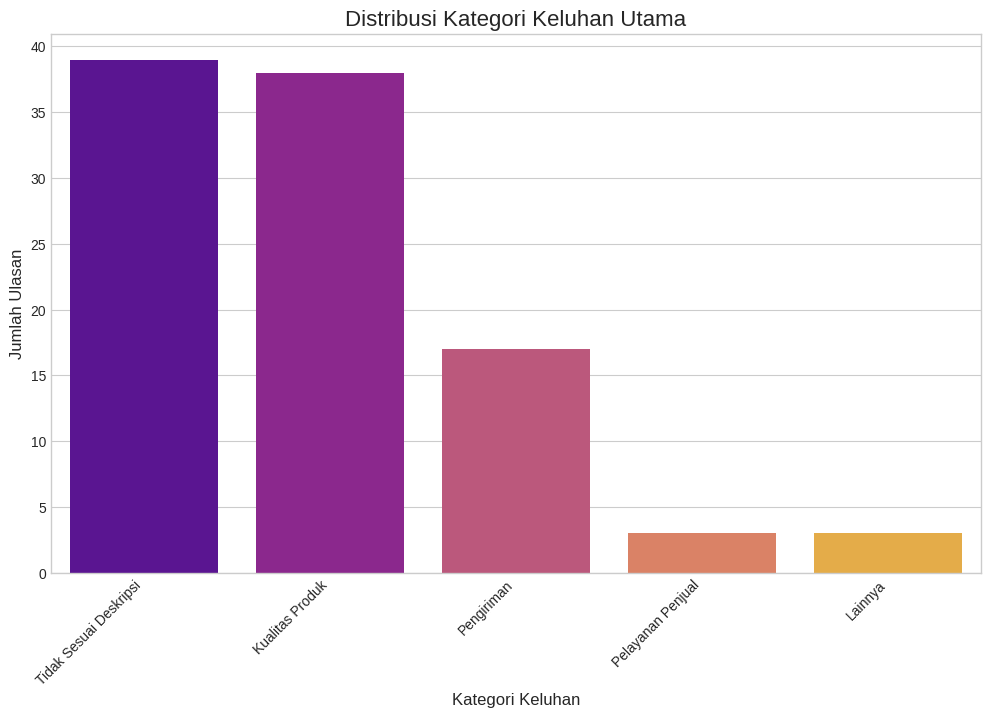

--- Ringkasan Keluhan dari AI ---

Ringkasan untuk Kategori: 'Tidak Sesuai Deskripsi'
1. Barang yang dikirim tidak sesuai dengan pesanan dan tidak layak untuk digunakan, seperti jok motor yang tidak dapat menembus.
2. Produk yang diperoleh memiliki keluhan kualitas, seperti staples yang tidak cukup dan ukuran yang tidak sesuai dengan deskripsi.
3. Kesulitan komunikasi dengan pihak penjual, termasuk tidak dapat mendapatkan respon dari chat, dan kekurangan informasi dalam pesan konfirmasi.

Ringkasan untuk Kategori: 'Kualitas Produk'
1. **Kualitas Barang Buruk**: Pelanggan mengeluh karena barang yang dibeli rusak atau jelek, tidak sesuai dengan yang dihadapkan, dan tidak layak untuk dipakai. Contohnya, staples yang gagal bekerja, barang cacat, dan kualitas bahan yang tidak seimbang.

2. **Kerusakan Pada Pengiriman**: Pelanggan juga menyampaikan keluhan terhadap kondisi keringatan produk saat sampir, yang tidak aman dan cacat. Selain itu, kualitas kembalikan produk yang buruk, seperti sep

In [40]:
# Hitung jumlah ulasan untuk setiap kategori keluhan
distribusi_keluhan = sampel_df['kategori_keluhan'].value_counts()

# Buat visualisasi
plt.figure(figsize=(12, 7))
sns.barplot(x=distribusi_keluhan.index, y=distribusi_keluhan.values, palette='plasma', hue=distribusi_keluhan.index, legend=False)
plt.title('Distribusi Kategori Keluhan Utama', fontsize=16)
plt.xlabel('Kategori Keluhan', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# Tampilkan ringkasan untuk kategori keluhan teratas
print("--- Ringkasan Keluhan dari AI ---")
for kategori in distribusi_keluhan.index:
    print(f"\nRingkasan untuk Kategori: '{kategori}'")
    # Ambil ulasan dari kategori ini
    ulasan_kategori = sampel_df[sampel_df['kategori_keluhan'] == kategori]['review_bersih'].tolist()
    # Buat ringkasannya
    ringkasan = buat_ringkasan(ulasan_kategori, llm)
    print(ringkasan)